In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -*- coding: utf-8 -*-
"""
ONE-FILE, ONE-RUN EDA (rebuild CSV v2 + make 3 reports: XOR / BF1 / HD)

✅ What you get in ONE execution:
1) Rebuild a NEW CSV with:
   - fixed perimeter (contour arcLength)
   - fixed edge_density (morph boundary density)
   - added min_linewidth/min_space (DT-based)
   - added metrics per stage: IoU, XOR, boundary-F1, Hausdorff (+ comp_delta)
2) Run EDA reports for THREE metric families:
   - XOR (higher = worse)
   - BF1 (higher = better; we report "error" as 1-BF1 for RQ1/2)
   - HD  (higher = worse)
3) Writes:
   - eda_6stage_features_errors_v2.csv
   - EDA_REPORT_XOR.txt
   - EDA_REPORT_BF1.txt
   - EDA_REPORT_HD.txt

Run:
  python eda_all_in_one.py

Dependencies:
  pip install numpy pandas opencv-python scipy scikit-learn
"""

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import cv2

from scipy.ndimage import distance_transform_edt
from scipy.spatial.distance import directed_hausdorff
from scipy.stats import spearmanr, mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance


# =========================================================
# CONFIG
# =========================================================
@dataclass
class BuildCFG:
    root: str = "/content/drive/MyDrive/StdMetal"
    folders: Tuple[str, ...] = ("litho", "pixelILT", "printed", "resist", "target")
    binary_stages: Tuple[str, ...] = ("target", "pixelILT", "printed")
    gray_stages: Tuple[str, ...] = ("litho", "resist")
    thresholds: Tuple[float, ...] = (0.30, 0.40, 0.50)
    morph_k: int = 3
    out_csv: str = "eda_6stage_features_errors_v2.csv"


@dataclass
class EDAcfg:
    prefer_thr: float = 0.40
    test_size: float = 0.25
    random_state: int = 42

    # RQ1 Shapley
    ridge_alpha: float = 1.0
    shapley_n_perms: int = 300
    bootstrap_B: int = 300

    # RQ2
    perm_repeats: int = 30
    spline_knots: int = 6
    spline_degree: int = 3

    # outputs (prefix)
    out_prefix: str = "EDA_REPORT"


BCFG = BuildCFG()
ECFG = EDAcfg()


# =========================================================
# PART 1) BUILD NEW CSV (v2)
# =========================================================
def list_files(folder: Path) -> Dict[str, Path]:
    return {p.name: p for p in folder.iterdir() if p.is_file()}


def build_index(cfg: BuildCFG) -> Tuple[Dict[str, Dict[str, Path]], List[str]]:
    root = Path(cfg.root)
    if not root.exists():
        raise FileNotFoundError(f"Root not found: {root.resolve()}")

    maps: Dict[str, Dict[str, Path]] = {}
    for f in cfg.folders:
        fp = root / f
        if not fp.exists():
            raise FileNotFoundError(f"Missing folder: {fp.resolve()}")
        maps[f] = list_files(fp)

    common = set(maps[cfg.folders[0]].keys())
    for f in cfg.folders[1:]:
        common &= set(maps[f].keys())
    common = sorted(common)
    if len(common) == 0:
        raise RuntimeError("No common filenames across folders.")

    print(f"[OK] common masks = {len(common)}")
    return maps, common


def load_as_float01(path: Path) -> np.ndarray:
    suf = path.suffix.lower()
    if suf == ".npy":
        arr = np.load(path)
        arr = np.asarray(arr)
        if arr.ndim == 3:
            arr = arr.mean(axis=-1)
        arr = arr.astype(np.float32)
        mn, mx = float(arr.min()), float(arr.max())
        if mx - mn < 1e-8:
            return np.zeros_like(arr, dtype=np.float32)
        return (arr - mn) / (mx - mn)

    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    return img.astype(np.float32) / 255.0


def otsu_binarize(img01: np.ndarray, auto_invert: bool = True) -> np.ndarray:
    img8 = np.clip(img01 * 255.0, 0, 255).astype(np.uint8)
    blur = cv2.GaussianBlur(img8, (5, 5), 0)
    _, b = cv2.threshold(blur, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b.astype(np.uint8)


def threshold_binarize(img01: np.ndarray, thr: float, auto_invert: bool = True) -> np.ndarray:
    b = (img01 > thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b


def cleanup_binary(bin01: np.ndarray, k: int) -> np.ndarray:
    if k is None or k <= 0:
        return bin01.astype(np.uint8)
    kernel = np.ones((k, k), np.uint8)
    x = cv2.morphologyEx(bin01.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, kernel)
    return x.astype(np.uint8)


def count_components(bin01: np.ndarray) -> int:
    num, _ = cv2.connectedComponents((bin01 > 0).astype(np.uint8), connectivity=4)
    return int(num - 1)


def contour_perimeter(bin01: np.ndarray) -> float:
    x = (bin01 > 0).astype(np.uint8) * 255
    cnts, _ = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        return 0.0
    return float(sum(cv2.arcLength(c, True) for c in cnts))


def morph_boundary_density(bin01: np.ndarray, k: int = 3) -> float:
    m = (bin01 > 0).astype(np.uint8)
    if m.sum() == 0:
        return 0.0
    kernel = np.ones((k, k), np.uint8)
    er = cv2.erode(m, kernel, iterations=1)
    boundary = (m ^ er).astype(np.uint8)
    return float(boundary.mean())


def min_linewidth_space_p5(bin01: np.ndarray) -> Dict[str, float]:
    m = (bin01 > 0)
    if m.sum() == 0:
        return {"target_min_linewidth_px_p5": 0.0, "target_min_space_px_p5": 0.0}

    dt_in = distance_transform_edt(m)
    dt_out = distance_transform_edt(~m)

    inside = dt_in[dt_in > 0]
    outside = dt_out[dt_out > 0]

    lw = 2.0 * float(np.percentile(inside, 5)) if inside.size else 0.0
    sp = 2.0 * float(np.percentile(outside, 5)) if outside.size else 0.0

    return {"target_min_linewidth_px_p5": lw, "target_min_space_px_p5": sp}


def extract_target_features_v2(target_bin: np.ndarray, morph_k: int) -> Dict[str, float]:
    area_frac = float(target_bin.mean())
    area = float(target_bin.sum()) + 1e-6

    perim = float(contour_perimeter(target_bin))
    comps = float(count_components(target_bin))
    compact = float((perim * perim) / area)

    edge_density = float(morph_boundary_density(target_bin, k=max(3, morph_k)))

    out = {
        "target_area_frac": area_frac,
        "target_perimeter": perim,
        "target_components": float(comps),
        "target_compactness": compact,
        "target_edge_density": edge_density,
    }
    out.update(min_linewidth_space_p5(target_bin))
    return out


def iou(a: np.ndarray, b: np.ndarray) -> float:
    a = (a > 0)
    b = (b > 0)
    inter = np.logical_and(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(inter / (uni + 1e-8))


def xor_rate(a: np.ndarray, b: np.ndarray) -> float:
    a = (a > 0)
    b = (b > 0)
    x = np.logical_xor(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(x / (uni + 1e-8))


def boundary_map(bin01: np.ndarray, k: int = 3) -> np.ndarray:
    m = (bin01 > 0).astype(np.uint8)
    if m.sum() == 0:
        return np.zeros_like(m, dtype=np.uint8)
    kernel = np.ones((k, k), np.uint8)
    er = cv2.erode(m, kernel, iterations=1)
    b = (m ^ er).astype(np.uint8)
    return b


def boundary_f1(a: np.ndarray, b: np.ndarray, k: int = 3) -> float:
    ba = boundary_map(a, k=k) > 0
    bb = boundary_map(b, k=k) > 0
    tp = np.logical_and(ba, bb).sum()
    fp = np.logical_and(ba, ~bb).sum()
    fn = np.logical_and(~ba, bb).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    return float(2 * prec * rec / (prec + rec + 1e-8))


def hausdorff_dist(a: np.ndarray, b: np.ndarray, k: int = 3) -> float:
    ba = boundary_map(a, k=k) > 0
    bb = boundary_map(b, k=k) > 0
    pts_a = np.column_stack(np.where(ba))
    pts_b = np.column_stack(np.where(bb))

    if len(pts_a) == 0 and len(pts_b) == 0:
        return 0.0
    if len(pts_a) == 0 or len(pts_b) == 0:
        h, w = a.shape
        return float(np.sqrt(h * h + w * w))

    d_ab = directed_hausdorff(pts_a, pts_b)[0]
    d_ba = directed_hausdorff(pts_b, pts_a)[0]
    return float(max(d_ab, d_ba))


def comp_delta(a: np.ndarray, b: np.ndarray) -> int:
    return int(count_components(b) - count_components(a))


def add_metrics(row: Dict[str, float], prefix: str, a: np.ndarray, b: np.ndarray, k: int) -> None:
    row[f"iou_{prefix}"] = iou(a, b)
    row[f"xor_{prefix}"] = xor_rate(a, b)
    row[f"bf1_{prefix}"] = boundary_f1(a, b, k=k)
    row[f"hd_{prefix}"] = hausdorff_dist(a, b, k=k)
    row[f"comp_delta_{prefix}"] = float(comp_delta(a, b))


def process_one(name: str, maps: Dict[str, Dict[str, Path]], cfg: BuildCFG) -> Dict[str, float]:
    imgs = {st: load_as_float01(maps[st][name]) for st in cfg.folders}

    bins = {}
    for st in cfg.binary_stages:
        b = otsu_binarize(imgs[st], auto_invert=True)
        b = cleanup_binary(b, cfg.morph_k)
        bins[st] = b

    gray_bins: Dict[str, Dict[float, np.ndarray]] = {}
    for st in cfg.gray_stages:
        gray_bins[st] = {}
        for t in cfg.thresholds:
            b = threshold_binarize(imgs[st], float(t), auto_invert=True)
            b = cleanup_binary(b, cfg.morph_k)
            gray_bins[st][float(t)] = b

    row: Dict[str, float] = {"mask_name": name}

    row.update(extract_target_features_v2(bins["target"], morph_k=cfg.morph_k))

    k = max(3, cfg.morph_k)

    add_metrics(row, "target_pixelILT", bins["target"], bins["pixelILT"], k=k)
    add_metrics(row, "target_printed", bins["target"], bins["printed"], k=k)

    for t in cfg.thresholds:
        lt = gray_bins["litho"][float(t)]
        add_metrics(row, f"pixelILT_litho_t{t:.2f}", bins["pixelILT"], lt, k=k)

    for t in cfg.thresholds:
        lt = gray_bins["litho"][float(t)]
        rt = gray_bins["resist"][float(t)]
        add_metrics(row, f"litho_resist_t{t:.2f}", lt, rt, k=k)

    for t in cfg.thresholds:
        rt = gray_bins["resist"][float(t)]
        add_metrics(row, f"resist_printed_t{t:.2f}", rt, bins["printed"], k=k)

    rp_xors = [row[f"xor_resist_printed_t{t:.2f}"] for t in cfg.thresholds]
    row["xor_resist_printed_mean"] = float(np.mean(rp_xors))
    row["xor_resist_printed_std"] = float(np.std(rp_xors))

    return row


def build_csv(cfg: BuildCFG) -> pd.DataFrame:
    maps, common = build_index(cfg)
    rows = []
    for i, name in enumerate(common, 1):
        try:
            rows.append(process_one(name, maps, cfg))
        except Exception as e:
            print(f"[ERROR] {name}: {e}")
        if i % 50 == 0 or i == len(common):
            print(f"Processed {i}/{len(common)}")
    df = pd.DataFrame(rows)
    df.to_csv(cfg.out_csv, index=False, encoding="utf-8-sig")
    print(f"[DONE] Saved {cfg.out_csv} | rows={len(df)} cols={df.shape[1]}")
    return df


# =========================================================
# PART 2) EDA REPORT (runs for XOR / BF1-error / HD)
# =========================================================
def _clean_numeric(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.columns:
        if c == "mask_name":
            continue
        if df[c].dtype == object:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


def cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if len(x) == 0 or len(y) == 0:
        return float("nan")
    gt = 0
    lt = 0
    for xi in x:
        gt += np.sum(xi > y)
        lt += np.sum(xi < y)
    return float((gt - lt) / (len(x) * len(y) + 1e-12))


def _fit_ridge_r2(Xtr, ytr, Xte, yte, alpha: float) -> float:
    m = Ridge(alpha=alpha, random_state=0)
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    return float(r2_score(yte, pred))


def shapley_r2_once(df: pd.DataFrame, y_col: str, x_cols: List[str], cfg: EDAcfg) -> Dict[str, float]:
    sub = df[[y_col] + x_cols].dropna().copy()
    idx = np.arange(len(sub))

    train_idx, test_idx = train_test_split(
        idx, test_size=cfg.test_size, random_state=cfg.random_state, shuffle=True
    )

    y = sub[y_col].to_numpy(dtype=float)
    X = sub[x_cols].to_numpy(dtype=float)

    ytr, yte = y[train_idx], y[test_idx]
    Xtr_all, Xte_all = X[train_idx], X[test_idx]

    full_r2 = _fit_ridge_r2(Xtr_all, ytr, Xte_all, yte, alpha=cfg.ridge_alpha)

    p = len(x_cols)
    contrib = np.zeros(p, dtype=float)
    rng = np.random.default_rng(cfg.random_state)

    for _ in range(cfg.shapley_n_perms):
        order = rng.permutation(p)

        y_base = np.full_like(yte, ytr.mean(), dtype=float)
        prev_r2 = float(r2_score(yte, y_base))

        chosen: List[int] = []
        for j in order:
            chosen.append(j)
            r2 = _fit_ridge_r2(Xtr_all[:, chosen], ytr, Xte_all[:, chosen], yte, alpha=cfg.ridge_alpha)
            contrib[j] += (r2 - prev_r2)
            prev_r2 = r2

    contrib /= float(cfg.shapley_n_perms)

    out = {x_cols[i]: float(contrib[i]) for i in range(p)}
    out["_full_r2"] = float(full_r2)
    out["_sum_contrib"] = float(contrib.sum())
    return out


def bootstrap_shapley(df: pd.DataFrame, y_col: str, x_cols: List[str], cfg: EDAcfg) -> pd.DataFrame:
    sub = df[[y_col] + x_cols].dropna().copy()
    n = len(sub)
    rng = np.random.default_rng(cfg.random_state)
    rows = []

    for b in range(cfg.bootstrap_B):
        boot = sub.iloc[rng.integers(0, n, size=n)].reset_index(drop=True)
        rows.append(shapley_r2_once(boot, y_col, x_cols, cfg))
        if (b + 1) % 50 == 0:
            print(f"bootstrap {b+1}/{cfg.bootstrap_B}")

    boot_df = pd.DataFrame(rows)

    for col in x_cols:
        boot_df[f"share_{col}"] = 100.0 * boot_df[col] / (boot_df["_sum_contrib"] + 1e-12)

    return boot_df


def summarize_bootstrap(boot_df: pd.DataFrame, x_cols: List[str]) -> Tuple[pd.DataFrame, Tuple[float, float, float]]:
    full = boot_df["_full_r2"].to_numpy()
    full_lo, full_mid, full_hi = np.percentile(full, [2.5, 50, 97.5])

    rows = []
    for col in x_cols:
        vals = boot_df[col].to_numpy()
        lo, mid, hi = np.percentile(vals, [2.5, 50, 97.5])

        share = boot_df[f"share_{col}"].to_numpy()
        slo, smid, shi = np.percentile(share, [2.5, 50, 97.5])

        rows.append({
            "process_var": col,
            "contrib_median": mid,
            "contrib_ci2.5": lo,
            "contrib_ci97.5": hi,
            "share_median_%": smid,
            "share_ci2.5_%": slo,
            "share_ci97.5_%": shi,
        })

    out = pd.DataFrame(rows).sort_values("share_median_%", ascending=False)
    return out, (full_lo, full_mid, full_hi)


def rq2_block(df: pd.DataFrame, y_col: str, feat_cols: List[str], cfg: EDAcfg) -> Dict[str, object]:
    sub = df[[y_col] + feat_cols].dropna().copy()
    X = sub[feat_cols].to_numpy(dtype=float)
    y = sub[y_col].to_numpy(dtype=float)

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=cfg.test_size, random_state=cfg.random_state, shuffle=True
    )

    model = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("spline", SplineTransformer(n_knots=cfg.spline_knots, degree=cfg.spline_degree, include_bias=False)),
        ("ridge", Ridge(alpha=cfg.ridge_alpha, random_state=0)),
    ])
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    r2 = float(r2_score(yte, pred))

    sp_rows = []
    for f in feat_cols:
        rho, p = spearmanr(sub[f].to_numpy(), sub[y_col].to_numpy(), nan_policy="omit")
        sp_rows.append((f, float(rho), float(p)))
    sp_df = pd.DataFrame(sp_rows, columns=["feature", "spearman_rho", "pval"])
    sp_df["abs_rho"] = sp_df["spearman_rho"].abs()
    sp_df = sp_df.sort_values("abs_rho", ascending=False).drop(columns=["abs_rho"])

    q_low, q_high = np.quantile(y, 0.10), np.quantile(y, 0.90)
    low_mask, high_mask = (y <= q_low), (y >= q_high)
    mw_rows = []
    for f in feat_cols:
        xl = sub.loc[low_mask, f].to_numpy(dtype=float)
        xh = sub.loc[high_mask, f].to_numpy(dtype=float)
        if len(xl) < 5 or len(xh) < 5:
            continue
        stat, p = mannwhitneyu(xh, xl, alternative="two-sided")
        cd = cliffs_delta(xh, xl)
        mw_rows.append((f, float(p), float(cd)))
    mw_df = pd.DataFrame(mw_rows, columns=["feature", "mw_pval", "cliffs_delta"]).sort_values("mw_pval", ascending=True)

    perm = permutation_importance(
        model, Xte, yte,
        n_repeats=cfg.perm_repeats,
        random_state=cfg.random_state,
        scoring="r2",
    )
    imp_df = pd.DataFrame({
        "feature": feat_cols,
        "perm_importance_mean": perm.importances_mean,
        "perm_importance_std": perm.importances_std,
    }).sort_values("perm_importance_mean", ascending=False)

    return {"n": len(sub), "r2": r2, "spearman": sp_df, "mw": mw_df, "perm": imp_df}


def _pick_feature_cols(df: pd.DataFrame) -> List[str]:
    candidates = [
        "target_area_frac",
        "target_perimeter",
        "target_components",
        "target_compactness",
        "target_edge_density",
        "target_min_linewidth_px_p5",
        "target_min_space_px_p5",
    ]
    return [c for c in candidates if c in df.columns]


def _stage_cols(prefix: str, thr: float) -> Dict[str, str]:
    t = float(thr)
    return {
        "Y_final": f"{prefix}_target_printed",
        "E0":      f"{prefix}_target_pixelILT",
        "E1":      f"{prefix}_pixelILT_litho_t{t:.2f}",
        "E2":      f"{prefix}_litho_resist_t{t:.2f}",
        "E3":      f"{prefix}_resist_printed_t{t:.2f}",
    }


def _write_report(
    path: str,
    metric_name: str,
    full_r2_ci: Tuple[float, float, float],
    rq1_df: pd.DataFrame,
    rq2_outputs: List[str],
):
    with open(path, "w", encoding="utf-8") as f:
        f.write(f"=== {metric_name} REPORT ===\n\n")
        f.write("RQ1) Shapley R² contributions (bootstrap 95% CI, proper shares)\n")
        f.write(f"- Full model R²: median={full_r2_ci[1]:.4f} | 95% CI [{full_r2_ci[0]:.4f}, {full_r2_ci[2]:.4f}]\n\n")
        f.write(rq1_df.to_string(index=False))
        f.write("\n\n")
        f.write("RQ2) Process-specific geometry drivers\n\n")
        for block in rq2_outputs:
            f.write(block)
            f.write("\n\n")


def run_eda_for_metric(df: pd.DataFrame, metric: str, cfg: EDAcfg) -> None:
    """
    metric:
      - "XOR": uses xor_* directly as "error"
      - "HD" : uses hd_* directly as "error"
      - "BF1": uses (1 - bf1_*) as "error" so 'higher = worse' like XOR/HD
    """
    prefer = cfg.prefer_thr
    feat_cols = _pick_feature_cols(df)
    if len(feat_cols) == 0:
        raise RuntimeError("No geometry feature columns found.")

    if metric == "XOR":
        cols = _stage_cols("xor", prefer)
        y_final = cols["Y_final"]
        x_cols = [cols["E0"], cols["E1"], cols["E2"]]
        df_use = df.copy()

    elif metric == "HD":
        cols = _stage_cols("hd", prefer)
        y_final = cols["Y_final"]
        x_cols = [cols["E0"], cols["E1"], cols["E2"]]
        df_use = df.copy()

    elif metric == "BF1":
        # convert similarity to error: err = 1 - bf1
        cols = _stage_cols("bf1", prefer)
        y_final = cols["Y_final"]
        x_cols = [cols["E0"], cols["E1"], cols["E2"]]
        df_use = df.copy()
        for k in cols.values():
            if k in df_use.columns:
                df_use[k] = 1.0 - df_use[k]
        metric = "BF1_ERROR(1-bf1)"

    else:
        raise ValueError("metric must be one of: XOR, BF1, HD")

    needed = [y_final] + x_cols
    missing = [c for c in needed if c not in df_use.columns]
    if missing:
        raise KeyError(f"Missing columns for {metric}: {missing}")

    print(f"\n================ {metric} ================")
    print("=== RQ1) Shapley R² contributions ===")

    boot = bootstrap_shapley(df_use, y_final, x_cols, cfg)
    rq1_df, full_ci = summarize_bootstrap(boot, x_cols)

    print(f"Full model R² median={full_ci[1]:.4f} | 95% CI [{full_ci[0]:.4f}, {full_ci[2]:.4f}]")
    print(rq1_df.to_string(index=False))

    print("\n=== RQ2) Process-specific geometry drivers ===")
    y_cols = {
        "Target→Printed(final)": y_final,
        "PixelILT→Litho": cols["E1"],
        "Litho→Resist": cols["E2"],
        "Resist→Printed": cols["E3"],
    }

    rq2_text_blocks = []
    for title, yc in y_cols.items():
        if yc not in df_use.columns:
            print(f"[SKIP] {title}: missing {yc}")
            continue

        block = rq2_block(df_use, yc, feat_cols, cfg)

        # pretty text for file
        txt = []
        txt.append(f"--- {title} | y={yc} ---")
        txt.append(f"[{title}] spline-ridge test R2 = {block['r2']:.4f} | n={block['n']}")
        txt.append("")
        txt.append("[Top Spearman | abs(rho)]")
        txt.append(block["spearman"].head(10).to_string(index=False))
        txt.append("")
        txt.append("[Top MW (high vs low 10%) | smallest p]")
        txt.append(block["mw"].head(10).to_string(index=False))
        txt.append("")
        txt.append("[Top permutation importance]")
        txt.append(block["perm"].head(10).to_string(index=False))
        rq2_text_blocks.append("\n".join(txt))

        # console
        print(f"\n--- {title} | y={yc} ---")
        print(f"[{title}] spline-ridge test R2 = {block['r2']:.4f} | n={block['n']}")
        print("\n[Top Spearman | abs(rho)]")
        print(block["spearman"].head(10).to_string(index=False))
        print("\n[Top MW (high vs low 10%) | smallest p]")
        print(block["mw"].head(10).to_string(index=False))
        print("\n[Top permutation importance]")
        print(block["perm"].head(10).to_string(index=False))

    out_path = f"{cfg.out_prefix}_{metric.replace('(', '').replace(')', '').replace('/', '_')}.txt"
    _write_report(out_path, metric, full_ci, rq1_df, rq2_text_blocks)
    print(f"\n[OK] wrote: {out_path}")


def main():
    # 1) rebuild CSV v2
    df = build_csv(BCFG)

    # 2) run 3 EDA reports (XOR / BF1-error / HD)
    df = _clean_numeric(df)
    run_eda_for_metric(df, "XOR", ECFG)
    run_eda_for_metric(df, "BF1", ECFG)
    run_eda_for_metric(df, "HD", ECFG)

    print("\n[DONE] All-in-one EDA finished.")
    print(f"- CSV: {BCFG.out_csv}")
    print(f"- Reports: {ECFG.out_prefix}_XOR.txt, {ECFG.out_prefix}_BF1_ERROR1-bf1.txt, {ECFG.out_prefix}_HD.txt")


if __name__ == "__main__":
    main()


[OK] common masks = 271
Processed 50/271
Processed 100/271
Processed 150/271
Processed 200/271
Processed 250/271
Processed 271/271
[DONE] Saved eda_6stage_features_errors_v2.csv | rows=271 cols=65

================ XOR ================
=== RQ1) Shapley R² contributions ===
bootstrap 50/300
bootstrap 100/300
bootstrap 150/300
bootstrap 200/300
bootstrap 250/300
bootstrap 300/300
Full model R² median=0.2943 | 95% CI [0.1280, 0.4114]
             process_var  contrib_median  contrib_ci2.5  contrib_ci97.5  share_median_%  share_ci2.5_%  share_ci97.5_%
     xor_target_pixelILT        0.257059       0.144823        0.363764       80.619510      61.283655       93.644395
  xor_litho_resist_t0.40        0.041923       0.007965        0.088358       13.352647       3.545031       26.464936
xor_pixelILT_litho_t0.40        0.018961       0.004377        0.042457        5.893348       2.189164       11.989129

=== RQ2) Process-specific geometry drivers ===

--- Target→Printed(final) | y=xor_target

/tmp/ipython-input-1434160272.py:490: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(sub[f].to_numpy(), sub[y_col].to_numpy(), nan_policy="omit")



--- Litho→Resist | y=bf1_litho_resist_t0.40 ---
[Litho→Resist] spline-ridge test R2 = 1.0000 | n=271

[Top Spearman | abs(rho)]
                   feature  spearman_rho  pval
          target_area_frac           NaN   NaN
          target_perimeter           NaN   NaN
         target_components           NaN   NaN
        target_compactness           NaN   NaN
       target_edge_density           NaN   NaN
target_min_linewidth_px_p5           NaN   NaN
    target_min_space_px_p5           NaN   NaN

[Top MW (high vs low 10%) | smallest p]
                   feature  mw_pval  cliffs_delta
          target_area_frac      1.0           0.0
          target_perimeter      1.0           0.0
         target_components      1.0           0.0
        target_compactness      1.0           0.0
       target_edge_density      1.0           0.0
target_min_linewidth_px_p5      1.0           0.0
    target_min_space_px_p5      1.0           0.0

[Top permutation importance]
                   featu

/tmp/ipython-input-1434160272.py:490: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(sub[f].to_numpy(), sub[y_col].to_numpy(), nan_policy="omit")



--- Resist→Printed | y=bf1_resist_printed_t0.40 ---
[Resist→Printed] spline-ridge test R2 = 1.0000 | n=271

[Top Spearman | abs(rho)]
                   feature  spearman_rho  pval
          target_area_frac           NaN   NaN
          target_perimeter           NaN   NaN
         target_components           NaN   NaN
        target_compactness           NaN   NaN
       target_edge_density           NaN   NaN
target_min_linewidth_px_p5           NaN   NaN
    target_min_space_px_p5           NaN   NaN

[Top MW (high vs low 10%) | smallest p]
                   feature  mw_pval  cliffs_delta
          target_area_frac      1.0           0.0
          target_perimeter      1.0           0.0
         target_components      1.0           0.0
        target_compactness      1.0           0.0
       target_edge_density      1.0           0.0
target_min_linewidth_px_p5      1.0           0.0
    target_min_space_px_p5      1.0           0.0

[Top permutation importance]
                  

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# =========================
# Load
# =========================
df = pd.read_csv("eda_6stage_features_errors_v2.csv")

TARGET = "xor_target_printed"
FEATURES = [
    "target_area_frac",
    "target_perimeter",
    "target_edge_density",
    "target_compactness",
    "target_components",
    "target_min_linewidth_px_p5",
    "target_min_space_px_p5",
]

X = df[FEATURES].copy()
y = df[TARGET].copy()

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# =========================
# 1) Correlation structure
# =========================
print("\n==============================")
print("1) FEATURE CORRELATION MATRIX")
print("==============================")
corr = pd.DataFrame(Xs, columns=FEATURES).corr()
print(corr.round(3))

# Hierarchical clustering on correlation
dist = 1 - np.abs(corr)
link = linkage(squareform(dist), method="average")
clusters = fcluster(link, t=0.3, criterion="distance")

print("\n[Correlation-based feature clusters]")
for c in sorted(set(clusters)):
    members = [FEATURES[i] for i in range(len(FEATURES)) if clusters[i] == c]
    print(f" Cluster {c}: {members}")

# =========================
# 2) VIF check
# =========================
print("\n==============================")
print("2) VARIANCE INFLATION FACTOR")
print("==============================")

vif_df = pd.DataFrame()
vif_df["feature"] = FEATURES
vif_df["VIF"] = [variance_inflation_factor(Xs, i) for i in range(Xs.shape[1])]
print(vif_df.sort_values("VIF", ascending=False).round(2))

# =========================
# 3) Ablation stability test
# =========================
print("\n==============================")
print("3) ABLATION TEST (remove 1 feature)")
print("==============================")

base_model = Ridge(alpha=1.0)
base_model.fit(Xs, y)
base_r2 = r2_score(y, base_model.predict(Xs))

print(f"[Baseline R²] = {base_r2:.4f}\n")

for f in FEATURES:
    sub_feats = [x for x in FEATURES if x != f]
    X_sub = scaler.fit_transform(df[sub_feats])
    m = Ridge(alpha=1.0)
    m.fit(X_sub, y)
    r2 = r2_score(y, m.predict(X_sub))
    print(f"Remove {f:<30s} → R² = {r2:.4f} (Δ {r2-base_r2:+.4f})")


1) FEATURE CORRELATION MATRIX
                            target_area_frac  target_perimeter  \
target_area_frac                       1.000             0.970   
target_perimeter                       0.970             1.000   
target_edge_density                    0.970             1.000   
target_compactness                     0.891             0.975   
target_components                      0.632             0.611   
target_min_linewidth_px_p5             0.313             0.148   
target_min_space_px_p5                -0.852            -0.879   

                            target_edge_density  target_compactness  \
target_area_frac                          0.970               0.891   
target_perimeter                          1.000               0.975   
target_edge_density                       1.000               0.975   
target_compactness                        0.975               1.000   
target_components                         0.612               0.562   
target_min_lin

In [8]:
print("\n==============================")
print("4) GROUP-LEVEL INTERPRETATION (UPDATED: 3-axis)")
print("==============================")

GROUPS = {
    # 네가 말한 3축
    "TOPOLOGICAL (components)": ["target_components"],
    "LITHO-LIMIT (min lw/space)": ["target_min_linewidth_px_p5", "target_min_space_px_p5"],
    "STRUCTURAL DENSITY (area/perim/edge/compact)": [
        "target_area_frac",
        "target_perimeter",
        "target_edge_density",
        "target_compactness",
    ],
}

def fit_r2(feats):
    Xg = StandardScaler().fit_transform(df[feats])
    mg = Ridge(alpha=1.0)
    mg.fit(Xg, y)
    return r2_score(y, mg.predict(Xg))

# 그룹 R²
rows = []
for g, feats in GROUPS.items():
    r2g = fit_r2(feats)
    rows.append((g, feats, r2g))

# 보기 좋게 출력
for g, feats, r2g in sorted(rows, key=lambda x: x[2], reverse=True):
    print(f"{g:<40s} | n_feats={len(feats)} | R²={r2g:.4f} | {feats}")

# (선택) 그룹끼리 더해졌을 때 설명력도 같이 확인 (발표 방어용)
print("\n[Optional: incremental / combined groups]")
order = [
    "LITHO-LIMIT (min lw/space)",
    "STRUCTURAL DENSITY (area/perim/edge/compact)",
    "TOPOLOGICAL (components)",
]
cur = []
for k in order:
    cur += GROUPS[k]
    r2c = fit_r2(cur)
    print(f"Add -> {k:<35s} | total_feats={len(cur)} | R²={r2c:.4f}")

print("\n[INTERPRETATION NOTE]")
print("- Structural density group is highly collinear internally (expect high VIF).")
print("- Litho-limit + components are more 'independent axes' and safer for causal-style interpretation.")


4) GROUP-LEVEL INTERPRETATION (UPDATED: 3-axis)
LITHO-LIMIT (min lw/space)               | n_feats=2 | R²=0.5463 | ['target_min_linewidth_px_p5', 'target_min_space_px_p5']
STRUCTURAL DENSITY (area/perim/edge/compact) | n_feats=4 | R²=0.2947 | ['target_area_frac', 'target_perimeter', 'target_edge_density', 'target_compactness']
TOPOLOGICAL (components)                 | n_feats=1 | R²=0.0209 | ['target_components']

[Optional: incremental / combined groups]
Add -> LITHO-LIMIT (min lw/space)          | total_feats=2 | R²=0.5463
Add -> STRUCTURAL DENSITY (area/perim/edge/compact) | total_feats=6 | R²=0.6896
Add -> TOPOLOGICAL (components)            | total_feats=7 | R²=0.7214

[INTERPRETATION NOTE]
- Structural density group is highly collinear internally (expect high VIF).
- Litho-limit + components are more 'independent axes' and safer for causal-style interpretation.


[OK] loaded eda_6stage_features_errors_v2.csv | shape=(271, 65)
[OK] features used: ['target_area_frac', 'target_min_linewidth_px_p5', 'target_min_space_px_p5', 'target_compactness', 'target_components', 'target_perimeter', 'target_edge_density']



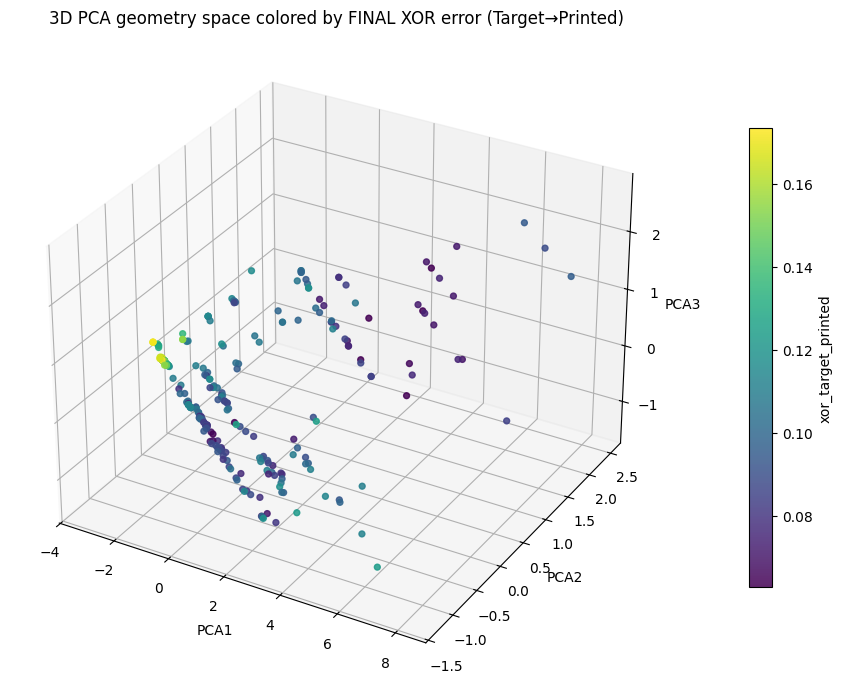

[shown] 3D PCA geometry space colored by FINAL XOR error (Target→Printed)



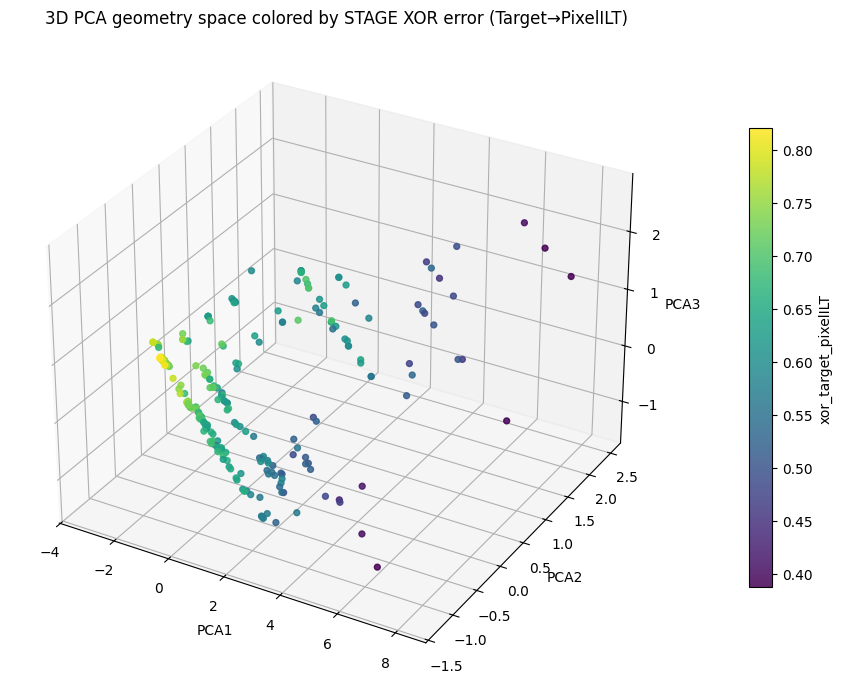

[shown] 3D PCA geometry space colored by STAGE XOR error (Target→PixelILT)



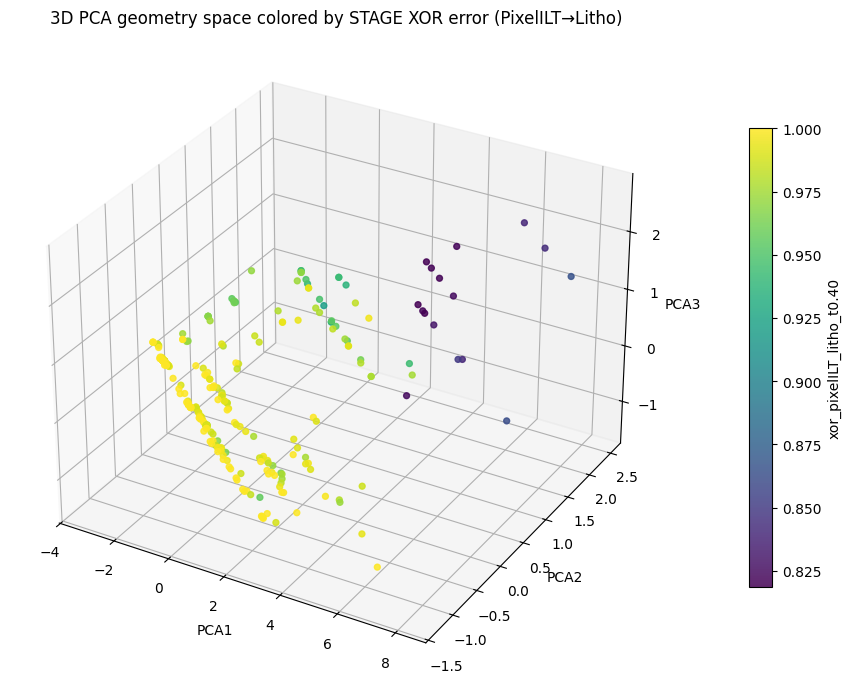

[shown] 3D PCA geometry space colored by STAGE XOR error (PixelILT→Litho)



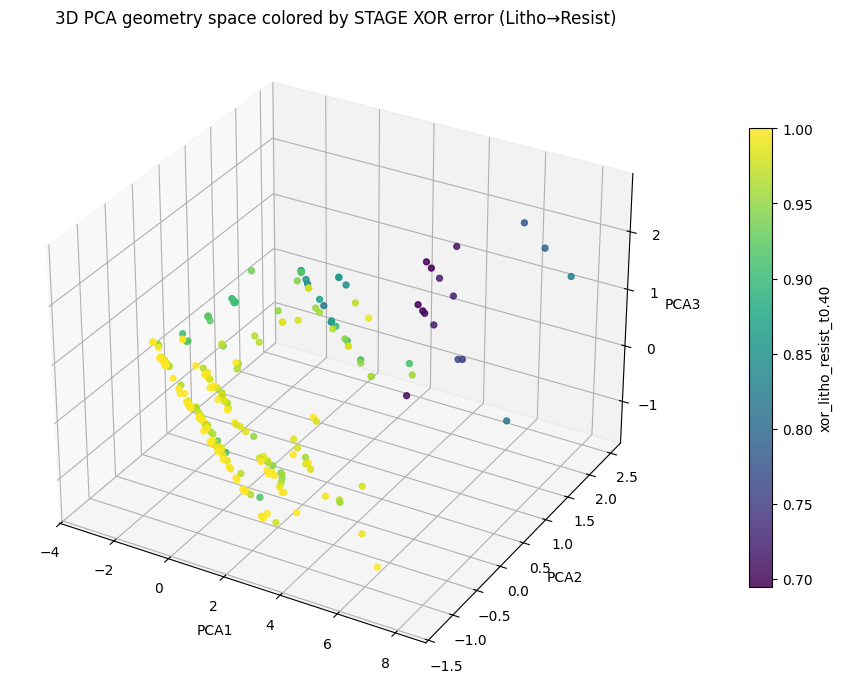

[shown] 3D PCA geometry space colored by STAGE XOR error (Litho→Resist)



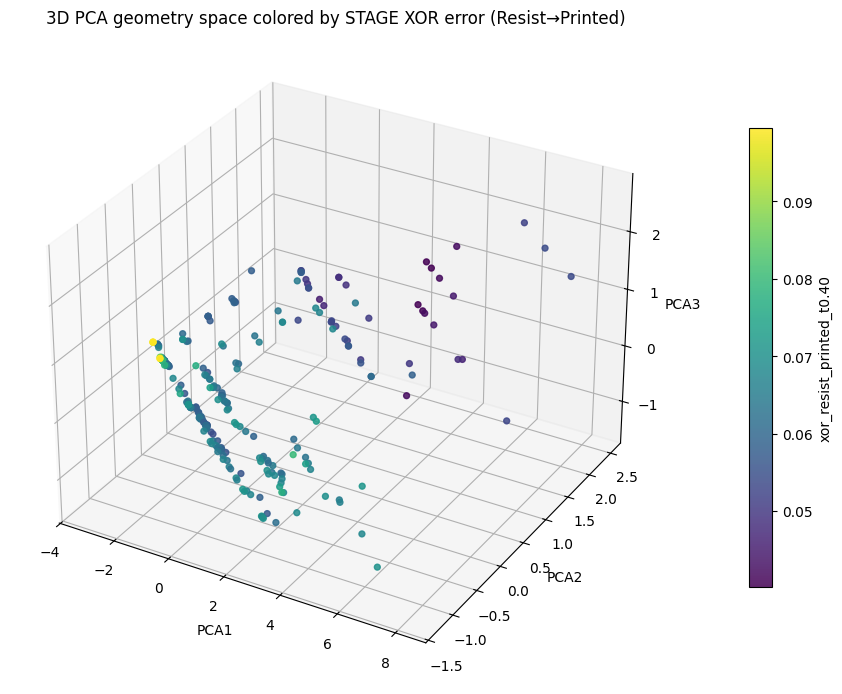

[shown] 3D PCA geometry space colored by STAGE XOR error (Resist→Printed)



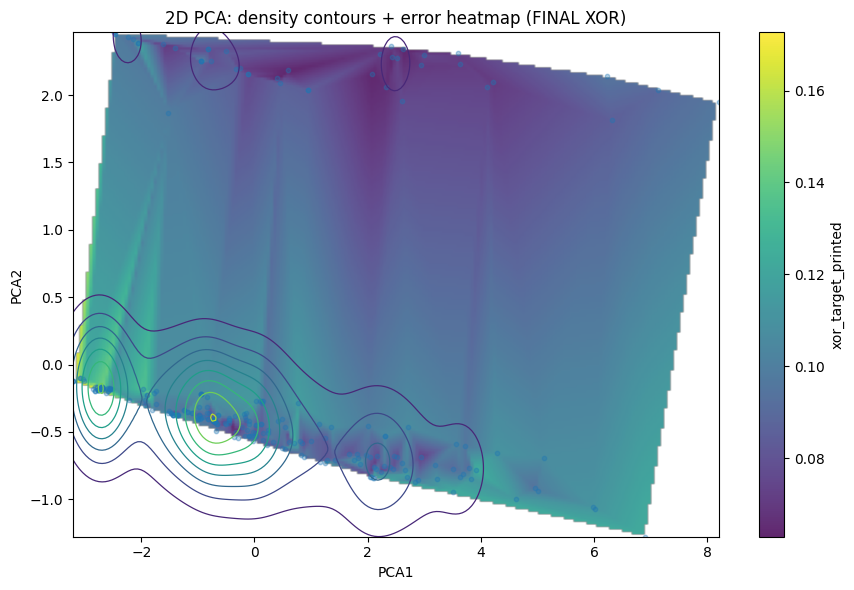

[shown] 2D PCA: density contours + error heatmap (FINAL XOR)



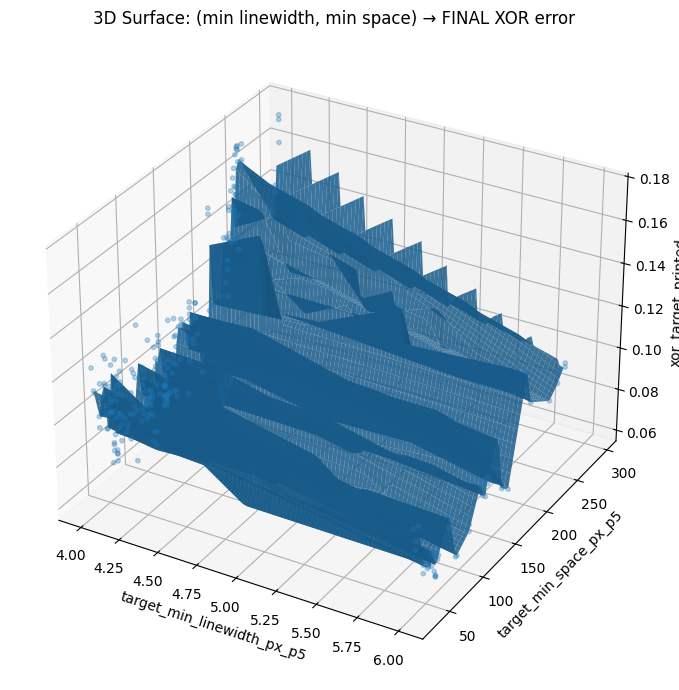

[shown] 3D Surface: (min linewidth, min space) → FINAL XOR error



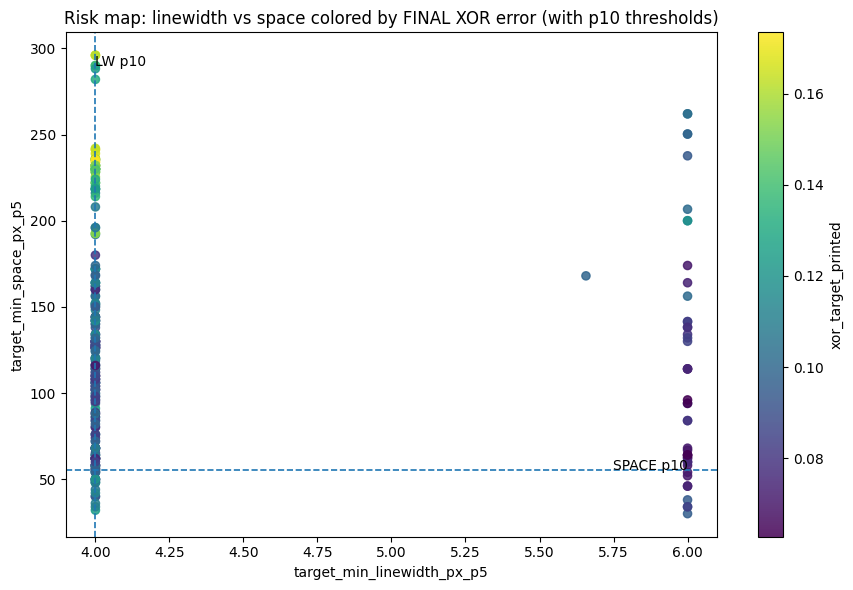

[shown] Risk map: linewidth vs space colored by FINAL XOR error (with p10 thresholds)



In [9]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from scipy.interpolate import griddata


# ======================
# SETTINGS
# ======================
CSV_PATH = "eda_6stage_features_errors_v2.csv"
THR = 0.40

Y_FINAL = "xor_target_printed"
Y_STAGE = {
    "Target→PixelILT": f"xor_target_pixelILT",
    "PixelILT→Litho": f"xor_pixelILT_litho_t{THR:.2f}",
    "Litho→Resist": f"xor_litho_resist_t{THR:.2f}",
    "Resist→Printed": f"xor_resist_printed_t{THR:.2f}",
}

FEATS = [
    "target_area_frac",
    "target_min_linewidth_px_p5",
    "target_min_space_px_p5",
    "target_compactness",
    "target_components",
    "target_perimeter",
    "target_edge_density",
]


# ======================
# Utils
# ======================
def clean_numeric(df: pd.DataFrame) -> pd.DataFrame:
    for c in df.columns:
        if c == "mask_name":
            continue
        if df[c].dtype == object:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def pick_feats(df: pd.DataFrame) -> list[str]:
    return [c for c in FEATS if c in df.columns]

def quantile_clip(x: np.ndarray, lo=0.01, hi=0.99) -> np.ndarray:
    a, b = np.quantile(x, [lo, hi])
    return np.clip(x, a, b)

def show(title: str):
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"[shown] {title}\n")


# ======================
# 1) 3D PCA scatter: "error landscape"
# ======================
def plot_3d_pca(df: pd.DataFrame, ycol: str, feat_cols: list[str], title: str):
    sub = df[[ycol] + feat_cols].dropna().copy()
    X = sub[feat_cols].to_numpy(float)
    y = sub[ycol].to_numpy(float)

    Xs = StandardScaler().fit_transform(X)
    Z = PCA(n_components=3, random_state=0).fit_transform(Xs)

    y_clip = quantile_clip(y)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=y_clip, s=18, alpha=0.85)

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")
    ax.set_title(title)

    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.1)
    cbar.set_label(ycol)

    show(title)


# ======================
# 2) 2D PCA density + error overlay (contour + heatmap)
# ======================
def plot_pca2_density_error(df: pd.DataFrame, ycol: str, feat_cols: list[str], title: str):
    sub = df[[ycol] + feat_cols].dropna().copy()
    X = sub[feat_cols].to_numpy(float)
    y = sub[ycol].to_numpy(float)

    Xs = StandardScaler().fit_transform(X)
    Z = PCA(n_components=2, random_state=0).fit_transform(Xs)

    gx, gy = np.mgrid[Z[:,0].min():Z[:,0].max():200j, Z[:,1].min():Z[:,1].max():200j]
    grid = np.vstack([gx.ravel(), gy.ravel()]).T

    kde = KernelDensity(bandwidth=0.35, kernel="gaussian").fit(Z)
    dens = np.exp(kde.score_samples(grid)).reshape(gx.shape)

    y_clip = quantile_clip(y)
    err = griddata(Z, y_clip, grid, method="linear").reshape(gx.shape)

    plt.figure(figsize=(9, 6))
    plt.contour(gx, gy, dens, levels=8, linewidths=0.9)

    im = plt.imshow(
        err.T, origin="lower",
        extent=(gx.min(), gx.max(), gy.min(), gy.max()),
        aspect="auto", alpha=0.85
    )

    plt.scatter(Z[:,0], Z[:,1], s=10, alpha=0.35)
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title(title)
    cbar = plt.colorbar(im)
    cbar.set_label(ycol)

    show(title)


# ======================
# 3) 3D surface: (min_linewidth, min_space) -> error (interpolation)
# ======================
def plot_3d_surface_two_feats(df: pd.DataFrame, x1: str, x2: str, ycol: str, title: str):
    sub = df[[x1, x2, ycol]].dropna().copy()
    x = sub[x1].to_numpy(float)
    z = sub[x2].to_numpy(float)
    y = sub[ycol].to_numpy(float)

    y_clip = quantile_clip(y)

    xi = np.linspace(np.quantile(x, 0.01), np.quantile(x, 0.99), 80)
    zi = np.linspace(np.quantile(z, 0.01), np.quantile(z, 0.99), 80)
    Xg, Zg = np.meshgrid(xi, zi)

    Yg = griddata(
        points=np.vstack([x, z]).T,
        values=y_clip,
        xi=(Xg, Zg),
        method="linear"
    )

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(Xg, Zg, Yg, rstride=1, cstride=1, linewidth=0, antialiased=True, alpha=0.85)
    ax.scatter(x, z, y_clip, s=10, alpha=0.30)

    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    ax.set_zlabel(ycol)
    ax.set_title(title)

    show(title)


# ======================
# 4) "Risk map" 2D scatter: linewidth vs space colored by error + thresholds
# ======================
def plot_risk_map(df: pd.DataFrame, x1: str, x2: str, ycol: str, title: str):
    sub = df[[x1, x2, ycol]].dropna().copy()
    x = sub[x1].to_numpy(float)
    y = sub[x2].to_numpy(float)
    e = quantile_clip(sub[ycol].to_numpy(float))

    plt.figure(figsize=(9, 6))
    sc = plt.scatter(x, y, c=e, s=35, alpha=0.85)
    plt.xlabel(x1)
    plt.ylabel(x2)
    plt.title(title)

    x_thr = np.quantile(x, 0.10)
    y_thr = np.quantile(y, 0.10)
    plt.axvline(x_thr, linestyle="--", linewidth=1.2)
    plt.axhline(y_thr, linestyle="--", linewidth=1.2)

    plt.text(x_thr, np.nanmax(y), "LW p10", va="top")
    plt.text(np.nanmax(x), y_thr, "SPACE p10", ha="right")

    cbar = plt.colorbar(sc)
    cbar.set_label(ycol)

    show(title)


# ======================
# RUN
# ======================
df = clean_numeric(pd.read_csv(CSV_PATH))
feat_cols = pick_feats(df)
print(f"[OK] loaded {CSV_PATH} | shape={df.shape}")
print(f"[OK] features used: {feat_cols}\n")

# 1) 3D PCA for final + stages
plot_3d_pca(df, Y_FINAL, feat_cols, "3D PCA geometry space colored by FINAL XOR error (Target→Printed)")
for stage_name, yc in Y_STAGE.items():
    if yc in df.columns:
        plot_3d_pca(df, yc, feat_cols, f"3D PCA geometry space colored by STAGE XOR error ({stage_name})")

# 2) 2D PCA density contour + error heat overlay (final)
plot_pca2_density_error(df, Y_FINAL, feat_cols, "2D PCA: density contours + error heatmap (FINAL XOR)")

# 3) 3D surface + 2D risk map (linewidth/space)
if "target_min_linewidth_px_p5" in df.columns and "target_min_space_px_p5" in df.columns:
    plot_3d_surface_two_feats(
        df,
        x1="target_min_linewidth_px_p5",
        x2="target_min_space_px_p5",
        ycol=Y_FINAL,
        title="3D Surface: (min linewidth, min space) → FINAL XOR error"
    )
    plot_risk_map(
        df,
        x1="target_min_linewidth_px_p5",
        x2="target_min_space_px_p5",
        ycol=Y_FINAL,
        title="Risk map: linewidth vs space colored by FINAL XOR error (with p10 thresholds)"
    )
else:
    print("[WARN] min_linewidth/min_space columns not found; skipping surface/risk-map.")